# Text Analytics - Classification 

In this notebook, we show the essential steps for performing text classification using a machine learning (ML) model. We use the Logistic Regression ML model for illustration. 



## Dataset

We use a corpora of emails to classify them into one of the two classes: spam and non-spam (ham). The dataset consists of labeled emails belonging to both ham (label = 0) and spam (label = 1).

URL: https://www.kaggle.com/karthickveerakumar/spam-filter



## Steps for Classification

Following are the general Natural Language Processing (NLP) steps for performing classification using a ML model.

1. Exploratory Data Analysis
2. Feature Extraction
   - a. Text Normalization
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vectorization of the features using the Bag-of-Words(BoW) model
3. Feature Scaling (required by some models)
4. Model Selection 
5. Train the Optimal Model
6. Evaluate the Model on Test Data

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package wordnet to /Users/hasan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

Load data from the CSV file as a Pandas DataFrame object.

In [2]:
df = pd.read_csv('/Users/hasan/datasets/emails.csv')

#  1. Exploratory Data Analysis

## Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## Get Information on the Pandas DataFrame Object

Use Pandas info method to print information about a DataFrame including the index dtype and columns, non-null values and memory usage.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


## Check if there are any null values in any columns

In [5]:
df.isna().values.any()

False

## Observation: NaN Values

We observe that there are no missing values (i.e., NaN values) in the DataFrame object.

If there exists any NaN values in the "text" column, we should remove the rows containing NaN values using the following method.

df = df[df['text'].notna()]

## Dimension of the Data

In [6]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5728, 2)

No. of Rows: 5728
No. of Columns: 2


## Class Distribution

In [7]:
df.groupby('spam').count()

,text
spam,
0,4360
1,1368


## Visualization of the Class Distribution

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


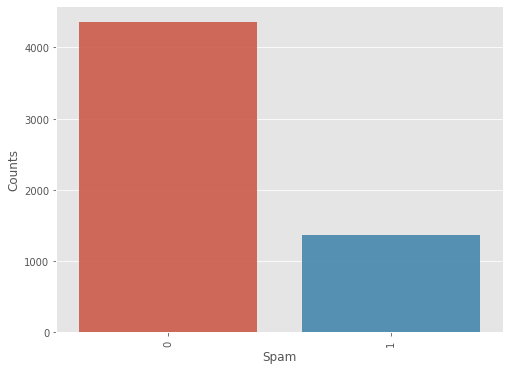

In [8]:
label_counts = df.spam.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

## Correlation Between the Email length & the Class (Ham/Spam)

We need to check whether the length of the emails are correlated to their classes (ham/spam).

In [9]:
# Create a new column "length" the stores the length of the text on each row
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('spam').length.describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4360.0,1631.918119,1959.664549,13.0,577.75,1122.0,2037.25,43952.0
1,1368.0,1317.257310,2271.372893,18.0,401.50,693.5,1250.25,28432.0


## Visualize Length Distribution by Class

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

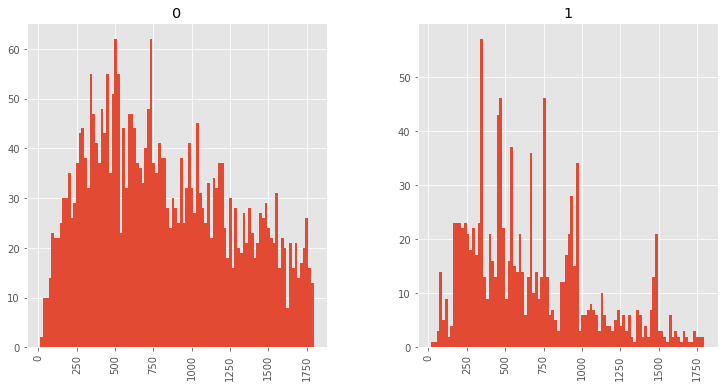

In [10]:
# Use a length threshold to visualize the distribution of length per class

threshold = 1800
emails_subset = df[df.length < threshold]
emails_subset.hist(column='length', by='spam', bins=100, figsize=(12, 6))

## Observation from the EDA

We observe that **only 23.88%** emails are spam.

Also there are some outliers (long emails).

# 2. Feature Extraction 

## a) Text Normalization by Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

Lemmatization is more suitable for text classification. It's the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or dictionary form. 

In [11]:
%%time
lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

CPU times: user 22.6 s, sys: 264 ms, total: 22.8 s
Wall time: 23.9 s


## Observe a Random Document Before and After Normalization

In [12]:
print("\nEmail (no lemmatization):\n")
print(df['text'][171])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][171])


Email (no lemmatization):

Subject: failure notice  hi . this is the qmail - send program at nsl . mxlinux 2 . com .  i ' m afraid i wasn ' t able to deliver your message to the following addresses .  this is a permanent error ; i ' ve given up . sorry it didn ' t work out .  :  this address no longer accepts mail .  - - - below this line is a copy of the message .  return - path :  received : ( qmail 30891 invoked from network ) ; 19 jul 2005 10 : 57 : 17 - 0000  received : from ntokymo 09176 . okym . nt . adsl . ppp . infoweb . ne . jp ( helo mailwisconsin . com ) ( 218 . 229 . 92 . 176 )  by wpc 2010 . amenworld . com with smtp ; 19 jul 2005 10 : 57 : 17 - 0000  received : from 205 . 214 . 42 . 66  ( squirrelmail authenticated user projecthoneypot @ projecthoneypot . org ) ;  by mailwisconsin . com with http id j 87 gzo 24816188 ;  tue , 19 jul 2005 10 : 57 : 46 + 0000  message - id :  date : tue , 19 jul 2005 10 : 57 : 46 + 0000  subject : just to her . . .  from : " barry castill

## Generate Wordcloud of the Spam Emails

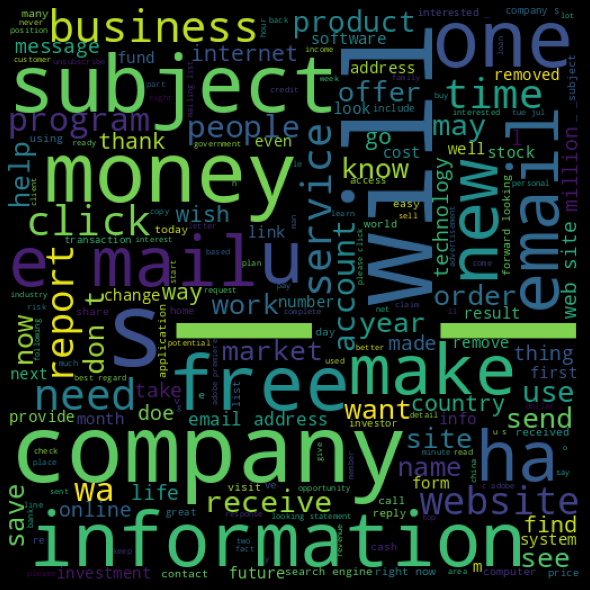

In [13]:
spam_words = ''.join(list(df[df['spam']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Generate Wordcloud of the Ham Emails

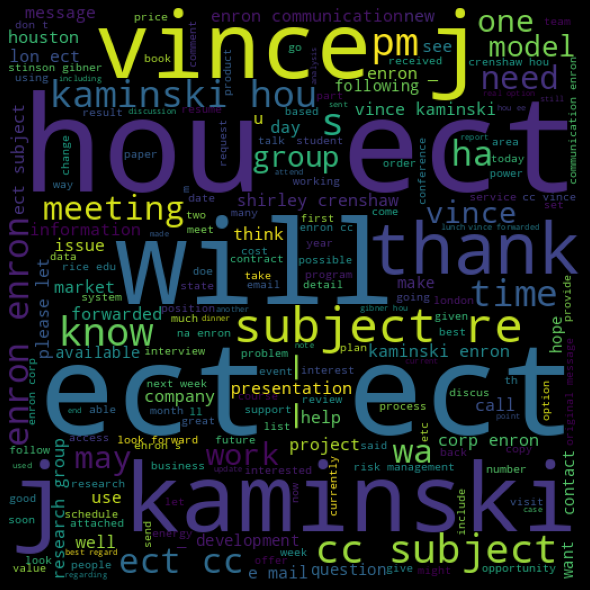

In [14]:
spam_words = ''.join(list(df[df['spam']==0]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Create a Separate Feature Set (Data Matrix X) and Target (1D Array y)

Create a data matrix (X) that contains all features and a 1D target array (y) containing the target.

First, we create separate DataFrame objects for X and y. Then, we convert the data frame objects into arrays.

In [15]:
X = df["text_lemmatized"] # DataFrame containing the target 
y = df['spam'] # DataFrame containing the features excluding the target

'''
Convert X & y into Arrays
Use the NumPy asarray() method to convert the Pandas data frame object X and y into numpy arrays.
'''

X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

print("Data Matrix (X) Shape: ", X.shape)
print("Label array (y) Shape: ", y.shape)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label array (y) Type: ", y.dtype)

# Read a random "email" from X
print("\nA random email:\n")
print(X[0])

Data Matrix (X) Shape:  (5728,)
Label array (y) Shape:  (5728,)

Data Matrix (X) Type:  object
Label array (y) Type:  int64

A random email:

subject : naturally irresistible your corporate identity lt is really hard to recollect a company : the market is full of suqgestions and the information isoverwhelminq ; but a good catchy logo , stylish statlonery and outstanding website will make the task much easier . we do not promise that havinq ordered a iogo your company will automaticaily become a world ieader : it isguite ciear that without good product , effective business organization and practicable aim it will be hotat nowadays market ; but we do promise that your marketing effort will become much more effective . here is the list of clear benefit : creativeness : hand - made , original logo , specially done to reflect your distinctive company image . convenience : logo and stationery are provided in all format ; easy - to - use content management system letsyou change your website c

## Create Train and Test Dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2(b) & 2(c). Text Preprocessing & Feature Vectorization


The following Scikit-Learn classes can perform both text preprocessing (tokenization, stop word removal) and feature vectorization. These classes utilize the BoW model for converting a collection of text documents into a matrix of token counts. 

- CountVectorizer(): converts tokens into their binary or frequency counts
- TfidfVectorizer(): converts tokens into their TF-IDF counts

These two classes can also perform text preprocessing, e.g., removing stop words. We only need to set the "stop_words" attribute value of the CountVectorizer/TfidfVectorizer object to 'english'.

Using the CountVectorizer() class, we can vectorize the tokens in the following two ways:
- Converts tokens into their binary counts (1 if the token appears in a document, otherwise 0). Set the "binary" attribute of CountVectorizer to True.
- Converts tokens into their frequencies (count the number of times a token appears in a document). It's the default setting of the CountVectorizer() class.

Below we show the code for using the CountVectorizer() class (both for binary count and frequency count) and TfidfVectorizer() class (for TF-IDF count).

## Use CountVectorizer() for Feature Vectorization

In [17]:
%%time

'''
Create a count vectorizer object using one of the following two techniques
For each technique, the stop word removal attribute is activated (which can be removed if needed)
Use one of the techniques (comment out the other one)
'''

#count_vect = CountVectorizer(binary=True, stop_words='english') # uses binary counts for vectorization
count_vect = CountVectorizer(stop_words='english') # uses frequency counts for vectorization


'''
Using the CountVectorizer object, create a matrix representation of the training documents
Each row represents a single document
Each column represents the binary count for each feature
'''
X_train_count_vectorized_features = count_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix Dimension: ", X_train_count_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(count_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_count_vectorized_features = count_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix Dimension: ", X_test_count_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_count_vectorized_features = np.asarray(X_train_count_vectorized_features) 
X_test_count_vectorized_features = np.asarray(X_test_count_vectorized_features) 


Count Vectorized Training Data Matrix Dimension:  (4582, 31065)

Size of Vocabulary:  31065

Count Vectorized Test Data Matrix Dimension:  (1146, 31065)
CPU times: user 1.12 s, sys: 232 ms, total: 1.35 s
Wall time: 1.36 s


## 3. Scale the Features

In [18]:
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train_count_vectorized_features)

# Apply transform to both the training set and the test set
X_train_count_vectorized_features = scaler.transform(X_train_count_vectorized_features)
X_test_count_vectorized_features = scaler.transform(X_test_count_vectorized_features)

## 4. Model Selection by Hyperparameter Tuning

We do not perform model selection in this notebook. But in practical problems, we must perform model selection (either via hyperparameter tuning or based on emprically evidenced optimal hyperparameters).


## 5. Train the Model

In [19]:
%%time

# We use the LogisticRegression model with its default setting
# But in practical problems, we must use the suitable values for the hyperparamters
model = LogisticRegression()

model.fit(X_train_count_vectorized_features, y_train)

CPU times: user 2min 29s, sys: 2.15 s, total: 2min 32s
Wall time: 23.2 s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 6. Evaluate the Model on Test Data

In [20]:
print("Test Accuracy: ", model.score(X_test_count_vectorized_features, y_test))

y_test_predicted = model.predict(X_test_count_vectorized_features)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9467713787085514

Test Confusion Matrix:
[[850   6]
 [ 55 235]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.99      0.97       856
        Real       0.98      0.81      0.89       290

    accuracy                           0.95      1146
   macro avg       0.96      0.90      0.93      1146
weighted avg       0.95      0.95      0.95      1146



## 2 - 6. Use TfidfVectorizer() for TF-IDF Feature Vectorization

In [21]:
%%time

# Create a TF-IDF vectorizer object 
# The stop word removal attribute is activated (which can be removed if needed)
tfidf_vect = TfidfVectorizer(stop_words='english')


# Using the TfidfVectorizer object, create a matrix representation of the training documents
# Each row represents a single document
# Each column represents the binary count for each feature
X_train_tfidf_vectorized_features = tfidf_vect.fit_transform(X_train).todense()

print("\nCount Vectorized Training Data Matrix (TF-IDF) Dimension: ", X_train_tfidf_vectorized_features.shape)
print("\nSize of Vocabulary: ", len(tfidf_vect.vocabulary_))


# Using the CountVectorizer object, create a matrix representation of the test documents
X_test_tfidf_vectorized_features = tfidf_vect.transform(X_test).todense()
print("\nCount Vectorized Test Data Matrix (TF-IDF) Dimension: ", X_test_tfidf_vectorized_features.shape)


# Convert the feature matrices into numpy ndarrays
X_train_tfidf_vectorized_features = np.asarray(X_train_tfidf_vectorized_features) 
X_test_tfidf_vectorized_features = np.asarray(X_test_tfidf_vectorized_features)


Count Vectorized Training Data Matrix (TF-IDF) Dimension:  (4582, 31065)

Size of Vocabulary:  31065

Count Vectorized Test Data Matrix (TF-IDF) Dimension:  (1146, 31065)
CPU times: user 1.23 s, sys: 267 ms, total: 1.5 s
Wall time: 1.54 s


In [22]:
%%time

# We use the LogisticRegression model with its default setting
# But in practical problems, we must use the suitable values for the hyperparamters
model = LogisticRegression()

model.fit(X_train_tfidf_vectorized_features, y_train)

CPU times: user 39.9 s, sys: 793 ms, total: 40.6 s
Wall time: 6.88 s


LogisticRegression()

In [23]:
print("Test Accuracy: ", model.score(X_test_tfidf_vectorized_features, y_test))

y_test_predicted = model.predict(X_test_tfidf_vectorized_features)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Fake", "Real"]))

Test Accuracy:  0.9799301919720768

Test Confusion Matrix:
[[854   2]
 [ 21 269]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      1.00      0.99       856
        Real       0.99      0.93      0.96       290

    accuracy                           0.98      1146
   macro avg       0.98      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146

